# Figure 6: Plot attention weights entropy.

In an independent foraging setting, attentions should.

In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from itertools import combinations

import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import torch.nn.functional as functional
from torch_geometric.data import Batch, Data, DataLoader
from itertools import product
import pandas as pd
import seaborn as sns

In [4]:
from collab_env.data.file_utils import expand_path, get_project_root

In [5]:
from collab_env.gnn.gnn import get_adjcency_from_debug_batch
from collab_env.gnn.plotting_utility import load_various_data, load_rollout
from scipy.stats import entropy

import starbars
from scipy.stats import ranksums

## Data

In [6]:
self_loops = True # TOC added 111225 10:48AM

In [7]:
data_names = ['boid_food_basic','boid_food_independent','boid_food_strong'] #'runpod/boid_single_species_basic']

# set short versions of dataset names
data_names_short = {}
data_names_short['boid_single_species_independent'] = 'idpnt'
data_names_short['boid_single_species_basic'] = 'boid'
data_names_short['boid_food_basic'] = 'foodbasic'
data_names_short['boid_food_independent'] = 'foodidpnt'
data_names_short['boid_food_strong'] = 'foodstrong'

### manual input model, result from model selection

In [8]:
ablation = 0
all_combinations = [
    ('boid_food_basic', 'vpluspplus_a', 0.005, 1, 0.5, 2, ablation),
    # or ('boid_food_basic', 'vpluspplus_a', 0.005, 3, 0.5, 0, ablation)
    #    if considering the noised version of the best seed that performed well noiseless
    #    results are the same
    ('boid_food_independent', 'vpluspplus_a', 0.005, 1, 0.5, 4, ablation),
    ('boid_food_strong', 'vpluspplus_a', 0.005, 1, 0.5, 0, ablation)
]

In [9]:
print('all combos ', all_combinations)

all combos  [('boid_food_basic', 'vpluspplus_a', 0.005, 1, 0.5, 2, 0), ('boid_food_independent', 'vpluspplus_a', 0.005, 1, 0.5, 4, 0), ('boid_food_strong', 'vpluspplus_a', 0.005, 1, 0.5, 0, 0)]


In [10]:
rollout_error = None
models_to_consider = [0, 1, 2]

In [11]:
rollout_results =  {}

model_names = {}
for ind in range(len(all_combinations)):

    data_name, model_name, n, h, vr, s, ablation = all_combinations[ind]

    print("ablation ", ablation)

    #if ablation:
    #    old_format = True
    #else:
    old_format = True
    spec = {
        "data_name": data_name,
        "head": h,
        "visual_range": vr,
        "seed": s,
        "rollout_starting_frame": 5,
        "noise": n,
        "seed": s,
        "old_format": old_format,
        "ablate": ablation,
        "self_loops": self_loops,
    }
    
    data_name_short = data_names_short[data_name]
    if ablation:
        model_save_name = f"{data_name_short}_\nn{n}_h{h}_vr{vr}_s{s}{'_selfloops' if self_loops else ''}_ablation"
    else:
        model_save_name = f"{data_name_short}_\nn{n}_h{h}_vr{vr}_s{s}{'_selfloops' if self_loops else ''}"

    
    #try:
        
    rollout_results[ind] = load_rollout(
            "vpluspplus_a", **spec)
    model_names[ind] = model_save_name
    print(f"{ind}, Successfully import {model_save_name}")
    #except:
    #    print(f"Cannot import {model_save_name}")


ablation  0
/Users/tc/ArchivedBoxSync/Research/Basis/collab-env-stuff/collab-gnn-updates/collab-environment/trained_models/runpod/boid_food_basic/rollouts/boid_food_basic_vpluspplus_a_n0.005_h1_vr0.5_s2_rollout5_selfloops.pkl
0, Successfully import foodbasic_
n0.005_h1_vr0.5_s2_selfloops
ablation  0
/Users/tc/ArchivedBoxSync/Research/Basis/collab-env-stuff/collab-gnn-updates/collab-environment/trained_models/runpod/boid_food_independent/rollouts/boid_food_independent_vpluspplus_a_n0.005_h1_vr0.5_s4_rollout5_selfloops.pkl
1, Successfully import foodidpnt_
n0.005_h1_vr0.5_s4_selfloops
ablation  0
/Users/tc/ArchivedBoxSync/Research/Basis/collab-env-stuff/collab-gnn-updates/collab-environment/trained_models/runpod/boid_food_strong/rollouts/boid_food_strong_vpluspplus_a_n0.005_h1_vr0.5_s0_rollout5_selfloops.pkl
2, Successfully import foodstrong_
n0.005_h1_vr0.5_s0_selfloops


In [12]:
datasets = load_various_data(data_names, 1, return_dict = True)

In [13]:
datasets.keys()

dict_keys(['boid_food_basic', 'boid_food_independent', 'boid_food_strong'])

## Parse adjacency matrix

In [14]:
models_to_consider = rollout_results.keys()
print(models_to_consider)

dict_keys([0, 1, 2])


In [15]:
print(model_names)
assert len(model_names) == len(rollout_results.keys())

{0: 'foodbasic_\nn0.005_h1_vr0.5_s2_selfloops', 1: 'foodidpnt_\nn0.005_h1_vr0.5_s4_selfloops', 2: 'foodstrong_\nn0.005_h1_vr0.5_s0_selfloops'}


In [16]:
STARTING_FRAME = 5
ENDING_FRAME = 55
MODEL_STARTING_FRAME = 3
NODE_NUM = 21 # 21 boids + 1 food

entropy_dict = {}
ratio_dict = {}
W_output_all = {}

for m in models_to_consider: #rollout_results:
    print(f"Parsing model {m}")
    
    dataname, model_name, n, h, vr, s, _ = all_combinations[ind]
    dataloader = datasets[dataname]["test_loader"]
    
    W_input, W_output = get_adjcency_from_debug_batch(
            rollout_results[m], dataloader, vr, STARTING_FRAME, ENDING_FRAME, MODEL_STARTING_FRAME, NODE_NUM
        )

    W_output_all[m] = W_output
    #print(f"W_output[{m}] diagonal = {W_output.diagonal()}")

Parsing model 0


/Users/tc/ArchivedBoxSync/Research/Basis/collab-environment-main/collab_env/gnn/gnn.py:269: RuntimeWarning: invalid value encountered in divide
  A_output = A / col_sum[np.newaxis, :]


Parsing model 1
Parsing model 2


In [17]:
# creating a dictionary with one specific color per group:

my_pal = {}
for m in rollout_results:

    dataname, model_name, n, h, vr, s,_ = all_combinations[m]
    d = data_names_short[dataname]
    print(d)
    if 'idpnt' in d:
        my_pal[m] = "C1"
    elif 'strong' in d:
        my_pal[m] = "C2"
    else:
        my_pal[m] = "C0"

foodbasic
foodidpnt
foodstrong


In [18]:
#ticklabels = [model_names[c] if isinstance(c, int) else c + '\ndata' for c in entropy_dict]
ticklabels = [a[0] for a in all_combinations]
print(ticklabels)

['boid_food_basic', 'boid_food_independent', 'boid_food_strong']


## Plot attention adjacency matrix entries

In [19]:
def return_food_location(species_configs):
    # find food location
    width = species_configs["A"]['width']
    height = species_configs["A"]['height']
    
    food_config = species_configs["food0"]
    x, y = food_config['x']/width, food_config['y']/height

    return [x, y]

In [20]:
def find_boids_close_to_food(food_loc, predicted_xy, species_configs):
    width = species_configs["A"]['width']
    food_visual_range = species_configs['A']["food_visual_range"]
    food_eating_range = species_configs['A']["food_eating_range"]

    dis = np.sqrt(np.sum((predicted_xy - np.array(food_loc).reshape((1,2))) ** 2, axis = 1))

    condition1 = dis <= food_visual_range/width
    condition2 = dis > food_eating_range/width
    
    return np.logical_and(condition1, condition2)

In [21]:
def figure_data_D(rollout_results, datasets, all_combinations, m_x, W, start_frame = 3, start = 0, end = 50):
    """
    example: m_x, m_y = ['boid_single_species_basic', 'boid_single_species_independent']
    
    TO DO: 
    1 - compare difference between boid-boid and boid-food attention weights instead of trying to eyeball the mean plots
    
    
    """

    dataname, model_name, n, h, vr, s, _ = all_combinations[m_x]
    dataloader = datasets[dataname]["test_loader"]
    
    _, species = list(dataloader)[0]
    all_bird_ind = species.ravel() == 0 #exclude food/environmental factor
    food_ind = species.ravel() == 1 #food
    #print(food_ind)

    batch_size = rollout_results[0][0]['actual'][0].shape[0]


    if "food" in dataname:
        species_configs = datasets[data_name]["species_configs"]
        food_loc = return_food_location(species_configs)

    entropy_x_all, sum_bird_x_all, sum_food_x_all, sum_bird_diag_all = [], [], [], []
    start_ = start - start_frame
    end_ = start_ + end - start
    print('keys ', W[0].keys())
    for file in W[0].keys():

        entropy_x_file = []
        sum_bird_x_file = []
        sum_bird_diag_file = []
        sum_food_x_file = []
        
        batch = int(np.floor(file/batch_size))
        file_within_batch = file % batch_size
        
        for frame in range(start, end):#range(len(models[m_x]["W_output"][0][file])):
            if "food" in dataname:
                predicted = rollout_results[0][batch]['predicted'][frame + start_frame][file_within_batch].squeeze()
                # restrict to the moments when boids can see food
                # so the adjacency matrix entries can have both nonzero boid and food elements.
                # suggested by Dima
                bird_ind = find_boids_close_to_food(food_loc, predicted, species_configs)
    
            else:
                bird_ind = all_bird_ind
    
            if len(bird_ind) == 0:
                continue
                  
            # print('W diagonal ', W[0][file][frame][:, all_bird_ind].diagonal())
            #print('W diagonal mean', np.mean(W[0][file][frame][:, all_bird_ind].diagonal()))
            diag_mean = np.mean(W[0][file][frame][:, all_bird_ind].diagonal())
            '''
            TOC -- 111225 8:59PM
            Zero out the diagonal to figure out the boid to other boid attention level 
            '''
            np.fill_diagonal(W[0][file][frame], 0.0)
            x = W[0][file][frame][:,bird_ind]
            # print('x = ', x)
    
            x_boid = x[bird_ind,:]/np.sum(x[bird_ind,:])
    
            entropy_x = entropy(x_boid, axis = 0)
            entropy_x_file.append(entropy_x)
        
            sum_bird_x = np.mean(x[bird_ind,:])
            # sum_food_x = np.mean(x[food_ind,:])
            sum_food_x = np.mean(W[0][file][frame][bird_ind, food_ind])
                
            sum_bird_x_file.append(sum_bird_x)
    
            sum_food_x_file.append(sum_food_x)
        
            
        
            sum_bird_diag_file.append(diag_mean)
    
        
                

        entropy_x_all.append(np.mean(np.concatenate(entropy_x_file)))
        sum_bird_x_all.append(np.mean(sum_bird_x_file))
        sum_bird_diag_all.append(np.mean(sum_bird_diag_file))
        sum_food_x_all.append(np.mean(sum_food_x_file))
    
    
    return entropy_x_all, sum_bird_x_all, sum_food_x_all, sum_bird_diag_all


In [22]:
MODEL_START_TIME = 5 #: W_output_all starts to record at frame 5
start = 0
end = 50

entropy_all = {}
sum_bird = {}
sum_food = {}
sum_diag = {}
for m in models_to_consider:
    entropy_all[m], sum_bird[m], sum_food[m], sum_diag[m] = figure_data_D(
        rollout_results[m], datasets, all_combinations, m, W_output_all[m], MODEL_START_TIME, start, end)

keys  dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218

/var/folders/1g/7vcyjmld3kn3nfn_nrtskt9r0000gq/T/ipykernel_6055/3543660135.py:65: RuntimeWarning: invalid value encountered in divide
  x_boid = x[bird_ind,:]/np.sum(x[bird_ind,:])
/Users/tc/VirtualEnvironments/collab-environment-main/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/tc/VirtualEnvironments/collab-environment-main/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


keys  dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218

In [23]:
for i in range(len(sum_diag)): 
    print(f'diag {i} mean ', np.mean(sum_diag[i]))

diag 0 mean  0.1267272
diag 1 mean  0.8750771
diag 2 mean  0.15561353


In [24]:
sum_food_df = pd.DataFrame(sum_food)
sum_bird_df = pd.DataFrame(sum_bird)

In [25]:
print(sum_food_df.head())
print('sum food \n', sum_food)
print('sum bird \n', sum_bird)

          0         1         2
0  0.076504  0.011736  0.084820
1  0.149762  0.015346  0.123553
2  0.089584  0.012592  0.087298
3  0.102307  0.013364  0.111125
4  0.152214  0.014641  0.124394
sum food 
 {0: [0.07650436, 0.14976153, 0.089583896, 0.10230697, 0.15221411, 0.088270314, 0.10680988, 0.10511542, 0.072268456, 0.089547984, 0.1140301, 0.0809894, 0.090976365, 0.12988263, 0.13417076, 0.09839383, 0.11867027, 0.0970738, 0.12140277, 0.09591156, 0.10076768, 0.10224147, 0.13555789, 0.15922637, 0.09472319, 0.15211387, 0.12170942, 0.08262863, nan, 0.096518345, 0.088325694, 0.1003359, 0.07243456, 0.10205355, 0.11438626, 0.07564464, 0.06141664, 0.14411256, 0.14974357, 0.112908624, 0.1580152, 0.08999126, 0.15121846, nan, 0.17762414, 0.1231338, 0.10530158, 0.09746426, 0.08617405, 0.17281765, 0.12308185, 0.06964361, 0.12729473, 0.076719604, 0.15215094, 0.09144002, 0.1566199, 0.09644039, 0.12726481, 0.118295915, 0.11943713, 0.09709725, 0.14933649, 0.06826932, 0.078438915, 0.07938563, 0.09748224

### Boid to boid

In [26]:
_, pvalue01_boid_gt_ind = ranksums(sum_bird_df[0], sum_bird_df[1],'greater',nan_policy = 'omit')
_, pvalue02_boid_lt_strong = ranksums(sum_bird_df[0], sum_bird_df[2],'greater',nan_policy = 'omit')
_, pvalue03_boid = ranksums(sum_bird_df[0], sum_food_df[0],'two-sided',nan_policy = 'omit')
_, pvalue04_ind = ranksums(sum_bird_df[1], sum_food_df[1],'less',nan_policy = 'omit')
_, pvalue05_strong = ranksums(sum_bird_df[2], sum_food_df[2],'less',nan_policy = 'omit')

print(pvalue01_boid_gt_ind, pvalue02_boid_lt_strong, pvalue03_boid, pvalue04_ind, pvalue05_strong )

3.279278018978942e-98 1.8605570243210845e-29 7.948622966091763e-06 2.2504754913824153e-98 8.153529059048566e-46


3.0 0.03
3.0 0.03


/var/folders/1g/7vcyjmld3kn3nfn_nrtskt9r0000gq/T/ipykernel_6055/1033482679.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(np.array(ticklabels)[order], rotation = 40)


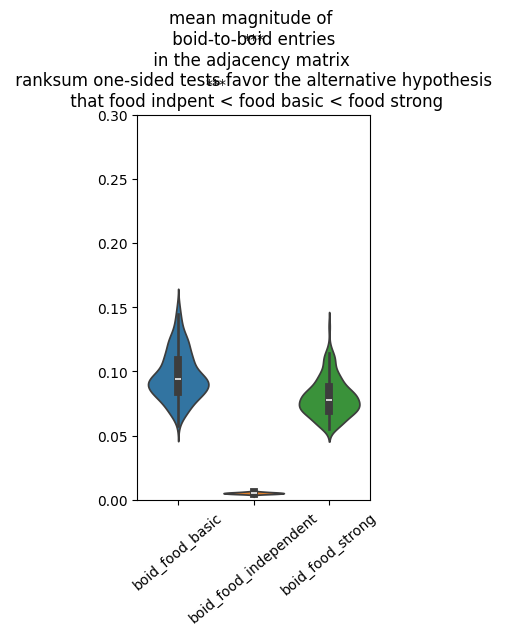

In [27]:
order = [0,1,2]
fig, axes = plt.subplots(nrows=1, ncols=1,
                         figsize=(3, 5))
                         #gridspec_kw={'height_ratios': [1, 3, 3]}) # Example 2x2 grid
ax = sns.violinplot(sum_bird_df, ax = axes, palette=my_pal, order = order)
ax.set_xticklabels(np.array(ticklabels)[order], rotation = 40)
ax.set_title("mean magnitude of \n boid-to-boid entries \n in the adjacency matrix  \n ranksum one-sided tests favor the alternative hypothesis \n that food indpent < food basic < food strong")
ax.set_ylim([0.0, 0.3])

# Annotate significance
annotations = [(0, 1, 0.001), (0, 2, 0.001)]
starbars.draw_annotation(annotations)
plt.savefig(f"food_adj_boid_sum{'_selfloops' if self_loops else ''}.pdf", bbox_inches="tight")

   boid-boid  boid-food
0   0.077575   0.076504
1   0.114677   0.149762
2   0.085569   0.089584
3   0.093776   0.102307
4   0.106828   0.152214
sum bird (300,)
sum food (300,)


<Axes: >

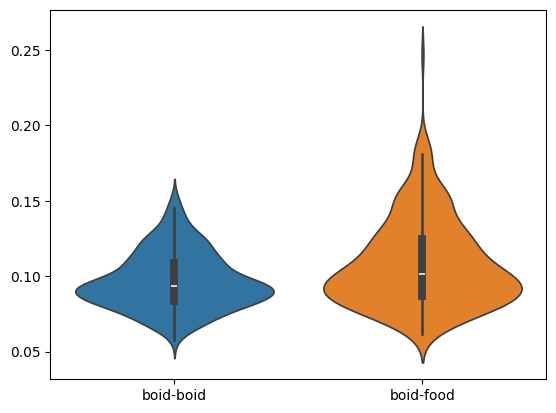

In [29]:
new_df = pd.DataFrame({'boid-boid': sum_bird_df[0], 'boid-food': sum_food_df[0]})
print(new_df.head())
print('sum bird', sum_bird_df[0].shape)
print('sum food', sum_food_df[0].shape)
order = [0,1]

                         #gridspec_kw={'height_ratios': [1, 3, 3]}) # Example 2x2 grid
# ax = sns.violinplot({'boid-boid': sum_bird_df[0], 'boid-food': sum_food_df[0]}, ax = axes[0], order = order)
sns.violinplot(new_df)

<Axes: >

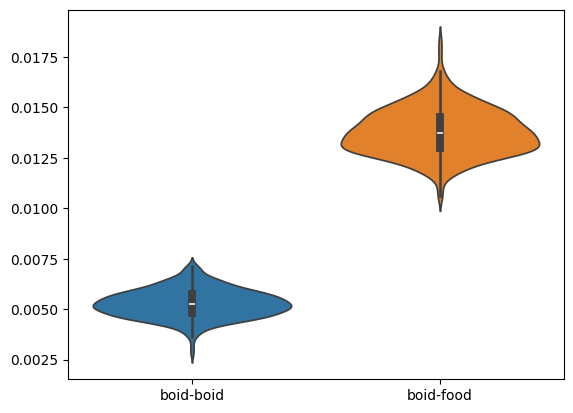

In [30]:
new_df = pd.DataFrame({'boid-boid': sum_bird_df[1], 'boid-food': sum_food_df[1]})

                         #gridspec_kw={'height_ratios': [1, 3, 3]}) # Example 2x2 grid
# ax = sns.violinplot({'boid-boid': sum_bird_df[0], 'boid-food': sum_food_df[0]}, ax = axes[0], order = order)
sns.violinplot(new_df)

<Axes: >

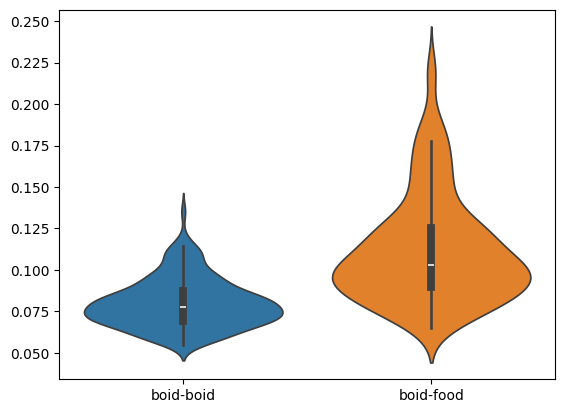

In [31]:
new_df = pd.DataFrame({'boid-boid': sum_bird_df[2], 'boid-food': sum_food_df[2]})

                         #gridspec_kw={'height_ratios': [1, 3, 3]}) # Example 2x2 grid
# ax = sns.violinplot({'boid-boid': sum_bird_df[0], 'boid-food': sum_food_df[0]}, ax = axes[0], order = order)
sns.violinplot(new_df)

### Boid to food

In [32]:
_, pvalue01 = ranksums(sum_food_df[0], sum_food_df[1],'greater',nan_policy = 'omit')
_, pvalue02 = ranksums(sum_food_df[0], sum_food_df[2],'less',nan_policy = 'omit')

print(pvalue01, pvalue02)

3.279278018978942e-98 0.12284777670822139


3.0 0.03
3.0 0.03


/var/folders/1g/7vcyjmld3kn3nfn_nrtskt9r0000gq/T/ipykernel_6055/1532545724.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(np.array(ticklabels)[order], rotation = 40)


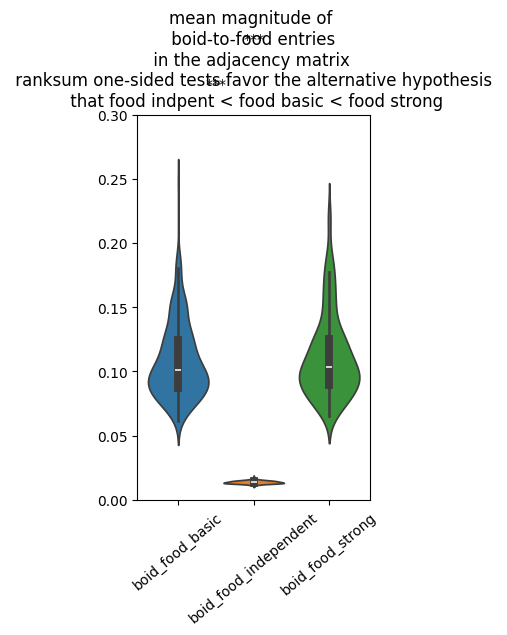

In [34]:
order = [0,1,2]
fig, axes = plt.subplots(nrows=1, ncols=1,
                         figsize=(3, 5))
                         #gridspec_kw={'height_ratios': [1, 3, 3]}) # Example 2x2 grid
ax = sns.violinplot(sum_food_df, ax = axes, palette=my_pal, order = order)
ax.set_xticklabels(np.array(ticklabels)[order], rotation = 40)
ax.set_title("mean magnitude of \n boid-to-food entries \n in the adjacency matrix  \n ranksum one-sided tests favor the alternative hypothesis \n that food indpent < food basic < food strong")
ax.set_ylim([0.0, 0.3])

# Annotate significance
annotations = [(0, 1, 0.001), (0, 2, 0.001)]
starbars.draw_annotation(annotations)
plt.savefig("food_adj_food_sum{'_selfloops' if self_loops else ''}.pdf", bbox_inches="tight")
